# Universidad de Buenos Aires
# Deep Learning - TP1
# Julio 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 28 de Julio inclusive. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y
visualizables en el colab. El colab debe poder ser ejecutado sin errores y las celdas no deben contener codigo que no corresponda con la ejecucion de las mismas.



## Ejercicio

Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y sobre eso los usuarios que han puntuado al menos 100 películas.

1- Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

2- A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

3- Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

4- Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

5- Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

6- Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

## <h1><center>TP1 - Aprendizaje profundo - CEIA</center></h1>

In [1]:
# Descargamos la carpeta con archivos auxiliares
%pip install gdown
!gdown https://drive.google.com/drive/folders/1khOHrQdJJCaWiw7gCTPW7YJjI2ILbBM2?usp=sharing --folder

# Exportamos los requrimientos para reproducción local
%pip freeze > requirements.txt

Retrieving folder contents
Retrieving folder 1BYbp5VwmGpGK0jv-serRtShl_QF79hMQ datasets
Processing file 1ZVshxm8UblIYqPBYxvZkOte5xuErsGAB ratings.csv
Retrieving folder 1Fgr-XEyleLdrZIMlfNxUI-e2K1ywMVe8 images
Processing file 1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg portada.jpeg
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ZVshxm8UblIYqPBYxvZkOte5xuErsGAB
To: /content/resources/datasets/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg
To: /content/resources/images/portada.jpeg
100% 362k/362k [00:00<00:00, 165MB/s]
Download completed


<center>

<img src="https://drive.google.com/uc?id=1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg" width="600" alt="Figura 1: An artificial brain with serveral movies photos inside it - Generada con Microsoft Image Creator">

<small><em>Figura 1: An artificial brain with serveral movies photos inside it - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<em>Datos del proyecto:</em>

| Subtitulo   | TP1 - Aprendizaje profundo - FIUBA                                                                                                     |
| ----------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Construcción de un sistema de recomendación de películas                          |
| **Integrantes** | • Bruno Masoller (brunomaso1@gmail.com)|

</center>

In [2]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import tempfile

🔧 <em><font color='tomato'><strong>Configuraciones:</strong></font></em>

In [3]:
# Parámetros
BATCH_SIZE = 32 # Tamaño del batch
N_EPOCHS = 30 # Número de épocas
VERBOSE = True # Muestra época a época la evolución
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Dispositivo actual: {DEVICE}')

Dispositivo actual: cuda


### Parte 1

> Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

*Primeramente, analizamos características del conjunto:*

In [4]:
# Cargamos el dataset.
# https://grouplens.org/datasets/movielens/latest/
df = pd.read_csv('/content/resources/datasets/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Mostramos datos estadísticos del conjunto.
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
# Mostramos los tipos de datos.
df.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


In [7]:
# Verficamos que no tenga duplicados ni valores nulos.
print(f'Datos duplicados: {df.duplicated().sum()}')
print(f'Valores nulos:\n{df.isnull().sum()}')

Datos duplicados: 0
Valores nulos:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


*Realizamos el filtrado para para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.*

In [8]:
# 1. Filtrar las 200 películas con mayor cantidad de votos
top_200_movies = df['movieId'].value_counts().head(200).index
df_top_movies = df[df['movieId'].isin(top_200_movies)]

In [9]:
# 1. Filtrar las 200 películas con mayor cantidad de votos
top_200_movies = df['movieId'].value_counts().head(200).index
df_top_movies = df[df['movieId'].isin(top_200_movies)]

# 2. Filtrar los usuarios que han votado al menos 100 películas
users_with_100_ratings = df_top_movies['userId'].value_counts()[df_top_movies['userId'].value_counts() >= 100].index
df_filtered = df_top_movies[df_top_movies['userId'].isin(users_with_100_ratings)]

# Mostrar el resultado
print(f"Total de registros después del filtrado: {len(df_filtered)}")
df_filtered.head()

Total de registros después del filtrado: 8329


,userId,movieId,rating,timestamp
1772,18,1,3.5,1455209816
1773,18,2,3.0,1455617462
1774,18,6,4.0,1460138360
1775,18,16,4.5,1461311583
1776,18,32,4.0,1455209840


*Una vez que chequeamos que el filtrado fue correcto, asignamos a nuestro dataframe original:*

In [10]:
df = df_filtered.copy()

*Eliminamos la columna timestamp que no nos aporta para este problema:*

In [11]:
df = df.drop('timestamp', axis=1)

### Parte 2

> A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

*Verificamos la cardinalidad de las características `userID` y `movieId`:*

In [12]:
print('Cardinalidad de userId: ', df['userId'].nunique())
print('Cardinalidad de movieId: ', df['movieId'].nunique())

Cardinalidad de userId:  63
Cardinalidad de movieId:  200


*Definimos la clase DataSet, necesaria por pytorch:*

In [13]:
# Construimos la clase Dataset
class MovieRatingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

*Definimos la arquitectura de la Red Neuronal:*

In [14]:
# Definimos la Redneuronal
class RecommenderNet(nn.Module):
  def __init__(self, num_users, num_movies, embedding_size=32):
    super(RecommenderNet, self).__init__()
    # Definimos los embedings.
    self.user_embedding = nn.Embedding(num_users, embedding_size)
    self.movie_embedding = nn.Embedding(num_movies, embedding_size)

    # Definimos las capas
    self.input_layer = nn.Linear(embedding_size * 2, 32)
    self.output_layer = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.5)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, X):
    # Obtenemos el id
    encoded_user_id = X[:, 0].long()
    encoded_movie_id = X[:, 1].long()

    # Obtenemos los embedings
    user_embedded = self.user_embedding(encoded_user_id)
    movie_embedded = self.movie_embedding(encoded_movie_id)

    # Concatenamos los embedings
    x = torch.cat([user_embedded, movie_embedded], dim=1)

    # Aplicamos las capas
    x = self.relu(self.input_layer(x))
    x = self.dropout(x)
    x = self.output_layer(x)
    x = self.sigmoid(x) * 4 + 1 # Transformar salida a rango [1, 5]
    return x.flatten() # Aplanamos el vector de salida (1D)

*Encodeamos las características `userId` y `movieId`:*

In [15]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

user_encoder.fit(df['userId'])
movie_encoder.fit(df['movieId'])

LabelEncoder()

*Dividimos los datos en entrenamiento y validación:*

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[['userId', 'movieId']], df['rating'], test_size=0.2, random_state=42)

*Aplicamos las transformaciones de los datos a __train__ y __validación__ por separado:*

In [17]:
X_train['userId'] = user_encoder.transform(X_train['userId'])
X_train['movieId'] = movie_encoder.transform(X_train['movieId'])

X_test['userId'] = user_encoder.transform(X_test['userId'])
X_test['movieId'] = movie_encoder.transform(X_test['movieId'])

*Creamos los `Dataset` y `DataLoader` de pytorch:*

In [18]:
train_dataset = MovieRatingDataset(X_train.values, y_train.values)
test_dataset = MovieRatingDataset(X_test.values, y_test.values)

# Para el train_loader configuramos suffle=True para que mezcle los datos.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

*Instanciamos la red (como parámetro, le pasamos la cantidad de clases de cada característica para los embedings):*

In [19]:
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)

# Instanciamos la red en el dispositivo seteado
model = RecommenderNet(num_users, num_movies).to(DEVICE)

*Definimos la función de costo. Para esta caso, utilizamos el MSE (Mean Square Error) dado que la salida es una regresión:*

In [20]:
criterion = nn.MSELoss()

*Definimos el optimizador. En este caso, Adam, con los parámetros por defecto:*

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

*Una vez definidos todos los puntos necesarios para problemas de aprendizaje profundo (arquitectura, función de costo y optimizador), entrenamos la red:*

In [23]:
# Listas para guardar los valores de pérdida
train_losses = []
test_losses = []
train_r2s = []
test_r2s = []

In [24]:
print('Training...\n')
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    train_r2 = 0.0
    test_r2 = 0.0

    train_y = []
    train_y_hat = []
    test_y = []
    test_y_hat = []

    # Entrenamiento
    model.train()  # Poner el modelo en modo de entrenamiento
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()   # Ponemos los parámetros del gradiente a 0

        y_batch_hat = model(X_batch) # Pasada forward
        loss = criterion(y_batch_hat, y_batch) # Computar la función de costo
        loss.backward()         # Propagar el error
        optimizer.step()        # Actualizar los parámetros.

        train_y += list(y_batch.detach().cpu().numpy())
        train_y_hat += list(y_batch_hat.detach().cpu().numpy())

        train_loss += loss.item() # Acumulamos el error.

    # Evaluación
    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():  # No necesitamos calcular gradientes durante la evaluación
        for (X_batch, y_batch) in test_loader:
            X_batch = X_batch.to(DEVICE).float()
            y_batch = y_batch.to(DEVICE).float()

            y_batch_hat = model(X_batch)
            loss = criterion(y_batch_hat, y_batch)

            test_y += list(y_batch.detach().cpu().numpy())
            test_y_hat += list(y_batch_hat.detach().cpu().numpy())
            test_loss += loss.item()

    train_loss /= len(train_loader)
    train_r2 = metrics.r2_score(train_y, train_y_hat)
    test_loss /= len(test_loader)
    test_r2 = metrics.r2_score(test_y, test_y_hat)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    if VERBOSE:
        print(f" Epoch {epoch + 1} | " \
        f"Train/Valid loss: {train_loss:.3f} / {test_loss:.3f} | " \
        f"Train/Valid r2: {train_r2:.3f} / {test_r2:.3f}")

print('\nFinished Training')

Training...

 Epoch 1 | Train/Valid loss: 0.933 / 0.730 | Train/Valid r2: -0.209 / 0.083
 Epoch 2 | Train/Valid loss: 0.729 / 0.682 | Train/Valid r2: 0.060 / 0.142
 Epoch 3 | Train/Valid loss: 0.683 / 0.650 | Train/Valid r2: 0.116 / 0.182
 Epoch 4 | Train/Valid loss: 0.637 / 0.627 | Train/Valid r2: 0.175 / 0.212
 Epoch 5 | Train/Valid loss: 0.612 / 0.604 | Train/Valid r2: 0.209 / 0.240
 Epoch 6 | Train/Valid loss: 0.584 / 0.583 | Train/Valid r2: 0.245 / 0.267
 Epoch 7 | Train/Valid loss: 0.560 / 0.574 | Train/Valid r2: 0.275 / 0.278
 Epoch 8 | Train/Valid loss: 0.556 / 0.567 | Train/Valid r2: 0.281 / 0.287
 Epoch 9 | Train/Valid loss: 0.543 / 0.560 | Train/Valid r2: 0.297 / 0.296
 Epoch 10 | Train/Valid loss: 0.540 / 0.556 | Train/Valid r2: 0.302 / 0.301
 Epoch 11 | Train/Valid loss: 0.526 / 0.552 | Train/Valid r2: 0.321 / 0.306
 Epoch 12 | Train/Valid loss: 0.528 / 0.548 | Train/Valid r2: 0.317 / 0.310
 Epoch 13 | Train/Valid loss: 0.519 / 0.545 | Train/Valid r2: 0.329 / 0.314
 Epoch 

### Parte 3

> Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

*Calculamos algunas métricas de evaluación:*

In [25]:
def imprimir_metricas_validacion(y_test, test_y_hat):
  mse = metrics.mean_squared_error(y_test, test_y_hat)
  rmse = np.sqrt(mse)
  mae = metrics.mean_absolute_error(y_test, test_y_hat)
  r2 = metrics.r2_score(y_test, test_y_hat)
  evs = metrics.explained_variance_score(y_test, test_y_hat)
  mape = metrics.mean_absolute_percentage_error(y_test, test_y_hat)

  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  print(f'R²: {r2}') # No tiene sentido, la varianza en este caso es 0 (son todos constantes los y)
  print(f'Explained Variance Score: {evs}') # No tiene sentido, la varianza en este caso es 0.
  print(f'MAPE: {mape}')

In [26]:
imprimir_metricas_validacion(y_test, test_y_hat)

MSE: 0.5545035483433175
RMSE: 0.7446499502070201
MAE: 0.5595016588970106
R²: 0.3138980546322534
Explained Variance Score: 0.31483213654192355
MAPE: 0.2091061850726172


*Graficamos la evolución del proceso:*

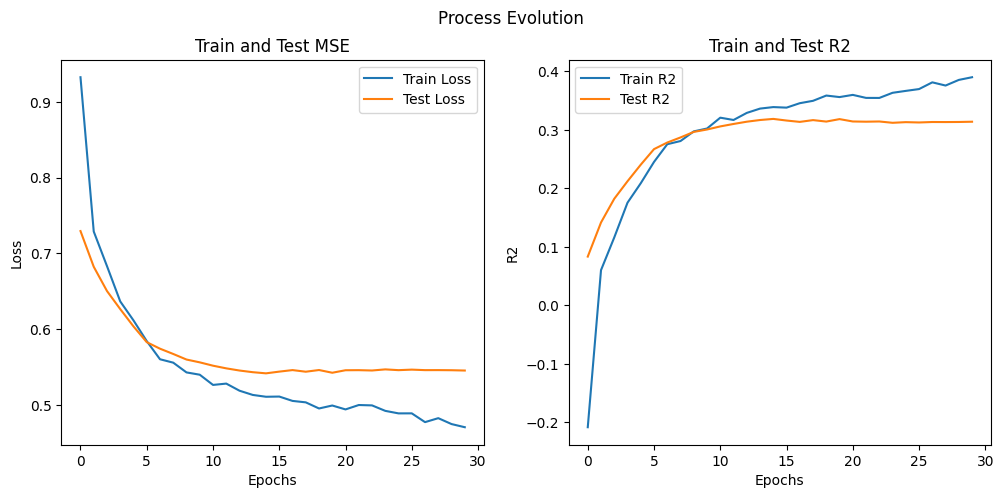

In [27]:
# Graficar las pérdidas (losses)
plt.figure(figsize=(12, 5))
plt.suptitle('Process Evolution')

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test MSE')
plt.legend()

# Graficar las R2
plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS), train_r2s, label='Train R2')
plt.plot(range(N_EPOCHS), test_r2s, label='Test R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.title('Train and Test R2')
plt.legend()

plt.show()


⭐**Conclusión**⭐

*En la evolución del proceso podemos ver que se reducen los erroes tanto en el conjunto de entrenamiento como en el de testing, lo que significa que la red no está pasando por una etapa de "overfiting" y está generalizando de forma correcta.*

*En este caso, luego de la 10 época ya no se logra reducir más el error en test y se empieza a oferfitear. No tiene sentido seguir entrenado, pero se deja en evidencia este caso, para ver si luego, en la optimización de hiperparámetros surge esta razón. También destacar que la métrica de RMSE llega a su mínimo en aproximadamente 0.74%, por lo que el modelo tiene una baja performance.*

*Esto puede ser porque se decidió encarar el problema como regresión (para hacerlo más realista) y no como clasificación (dado que este dataset tiene únicamente calificaciones con diferencias de 0.5).*

No se hizo un análisis exhaustivo de los datos, para ver las distribuciones de los usuarios/películas, más allá del filtrado. Probablemente se puedan aplicar técnias de over-sampling y uneder-sampling

Early stopping

<em>
Inicialmente, la red consistia de la siguiente arquitectura:

```python
class RecommenderNet(nn.Module):
  def __init__(self, num_users, num_movies, embedding_size=50):
    super(RecommenderNet, self).__init__()
    # Definimos los embedings.
    self.user_embedding = nn.Embedding(num_users, embedding_size)
    self.movie_embedding = nn.Embedding(num_movies, embedding_size)

    # Definimos las capas
    self.input_layer = nn.Linear(embedding_size * 2, 128)
    self.hidden_layer = nn.Linear(128, 32)
    self.output_layer = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.2)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, X):
    # Obtenemos el id
    encoded_user_id = X[:, 0].long()
    encoded_movie_id = X[:, 1].long()

    # Obtenemos los embedings
    user_embedded = self.user_embedding(encoded_user_id)
    movie_embedded = self.movie_embedding(encoded_movie_id)

    # Concatenamos los embedings
    x = torch.cat([user_embedded, movie_embedded], dim=1)

    # Aplicamos las capas
    x = self.relu(self.input_layer(x))
    x = self.dropout(x)
    x = self.relu(self.hidden_layer(x))
    x = self.dropout(x)
    x = self.output_layer(x)
    x = self.sigmoid(x) * 4 + 1 # Transformar salida a rango [1, 5]
    return x.flatten() # Aplanamos el vector de salida (1D)
```

Con el siguiente optimizador:

```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

El problema era que había mucho overfitting. Para solucionar este problema, luego de varias iteraciones, se cambió a la arquitectura actual. Las iteraciones fueron las siguientes:

1. Primeramente, se cambió el Dropout, de 0.2, a 0.5.
2. Dado que no se mejoraba, se agregó el parámetro `weight_decay` al optimizador (penalización L2).
3. Se mejoró un poco, pero finalmente se modificó a una arquitectura más ligera de la red, obteniendo el resultado mostrado.
4. Como última medida, se agregó regularización L2 a los embbedings:

```
self.user_embedding = nn.Embedding(num_users, embedding_size, max_norm=1)
self.movie_embedding = nn.Embedding(num_movies, embedding_size, max_norm=1)
```

</em>

<font color='MediumSeaGreen'>✔</font> *Mejoras posibles:* <font color='MediumSeaGreen'>✔</font>

<em>

Como posibles mejoras, se plantea lo siguiente:
- Inicialmente, codificar un early-stopping, ya que luego de la décima época no tiene sentido entrenar y se overfitea la red.
- Dado que no se hizo un análisis exhaustivo de los datos, habría que ver como están balanceadas las clases.
- Experimentar otras técnicas de dropout (DropConnect).
- Probar con otros valores de regularización del optimizador.

</em>

### Parte 4

> Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

*Cantidad de usuarios y películas en el dataset:*

In [29]:
# Cantidad de usuarios/peliculas
df.groupby('userId').count()

,movieId,rating
userId,,
18,133,133
19,107,107
28,109,109
45,130,130
57,109,109
...,...,...
600,146,146
603,102,102
606,131,131


*Función para predecir el score de un usuario (user_id) dado una cantidad de películas:*

In [30]:
def verify_movie_score(model: nn.Module, user_encoder: LabelEncoder, movie_encoder: LabelEncoder, df: pd.DataFrame, user_id: int, p: int = 5) -> pd.DataFrame:
    """
    Predice las puntuaciones de películas para un usuario específico y compara las predicciones con las puntuaciones reales.

    Args:
        model (nn.Module): El modelo de recomendación entrenado.
        user_encoder (LabelEncoder): Codificador para transformar IDs de usuarios.
        movie_encoder (LabelEncoder): Codificador para transformar IDs de películas.
        df (pd.DataFrame): DataFrame que contiene las puntuaciones de las películas.
        user_id (int): ID del usuario para el cual se realizarán las predicciones.
        p (int, opcional): Número de películas a evaluar para el usuario. Por defecto es 5.

    Returns:
        pd.DataFrame: DataFrame que contiene las puntuaciones reales, las puntuaciones predichas y las categorías de las puntuaciones predichas.
    """

    # Filtrar las primeras p filas del usuario especificado
    user_data = df.loc[df['userId'] == user_id].head(p).copy()
    if user_data.empty:
        print(f'No hay datos para el usuario {user_id}')
        return None

    # Obtener las categorías de puntuación únicas y ordenarlas en orden descendente
    df_ratings_categories = sorted(df['rating'].unique(), reverse=True)

    # Codificar los IDs del usuario y las películas y convertirlos en tensores
    user_data['userId'] = user_encoder.transform(user_data['userId'])
    user_data['movieId'] = movie_encoder.transform(user_data['movieId'])
    X_batch = torch.tensor(user_data[['userId', 'movieId']].values).to(DEVICE)
    y_batch = torch.tensor(user_data['rating'].to_numpy()).float().reshape(-1, 1).to(DEVICE)

    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(DEVICE)

    # Poner el modelo en modo de evaluación y deshabilitar el cálculo de gradientes
    model.eval()
    with torch.no_grad():
        # Realizar predicciones con el modelo
        y_batch_hat = model(X_batch)

    # Convertir las predicciones a un arreglo numpy
    y_batch_hat = y_batch_hat.detach().cpu().numpy().flatten()

    # Aplicamos la transformación inversa del encoder
    user_data['userId'] = user_encoder.inverse_transform(user_data['userId'])
    user_data['movieId'] = movie_encoder.inverse_transform(user_data['movieId'])

    # Asignamos la categoría de puntuación predicha redondeando cada predicción al valor más cercano en df_ratings_categories
    # Encuentra el valor más cercano a 'pred' en df_ratings_categories
    # Itera sobre cada predicción en y_batch_hat
    user_data['predicted_rating_category'] = [min(df_ratings_categories, key=lambda x: abs(x - pred)) for pred in y_batch_hat]

    # Añadir las predicciones al DataFrame
    user_data['predicted_rating'] = y_batch_hat

    # Calcular el error cuadrático medio (MSE) entre las puntuaciones reales y las predicciones
    user_data['MSE'] = metrics.mean_squared_error(y_batch.detach().cpu().numpy(), y_batch_hat)

    return user_data

*Ejemplos de uso:*

In [47]:
# NOTA: Si el dispositivo es GPU, cambia el orden del cojunto, por lo que cambian
# los usuarios.
if DEVICE == 'cuda':
    test_userId, test_p = 18, 5
else:
    test_userId, test_p = 1, 5

verify_movie_score(model, user_encoder, movie_encoder, df, test_userId, test_p)

,userId,movieId,rating,predicted_rating_category,predicted_rating,MSE
1772,18,1,3.5,4.0,3.819123,0.070839
1773,18,2,3.0,3.5,3.301711,0.070839
1774,18,6,4.0,3.5,3.717449,0.070839
1775,18,16,4.5,4.0,4.218395,0.070839
1776,18,32,4.0,4.0,4.046783,0.070839


### Parte 5

> Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

<em>El algoritmo ideado en este caso es el siguiente:
1. Recibir un id de usuario.
2. Obtener la película mejor puntuada para dicho usuario.
3. Obtener el embeding de dicha película.
4. Devolver las n películas más similares (utilizando la métrica de similitud de coseno) a la pelicula anteriormente encontrada.
</em>





In [41]:
def obtener_mejor_pelicula_puntuada(user_id: int, df: pd.DataFrame) -> pd.Series:
  # Obtener las puntuaciones que dicho usuario realizó.
  user_ratings = df[df['userId'] == user_id]

  # Devolver la película mejor puntuada.
  return user_ratings.loc[user_ratings['rating'].idxmax()]['movieId']

In [42]:
def recomendar_peliculas(model: nn.Module, movie_encoder: LabelEncoder, df: pd.DataFrame, user_id: int, n: int = 5) -> pd.DataFrame:
  # Obtener la mejor pelicula puntuada por el usuario.
  best_movie_id = obtener_mejor_pelicula_puntuada(user_id, df)

  # Encodear el id de película
  best_movie_id_encoded = movie_encoder.transform([best_movie_id])

  # Obtener el embedding de la mejor pelicula
  best_movie_embedding = model.movie_embedding(torch.tensor(best_movie_id_encoded, device=DEVICE)).detach().cpu().numpy()

  # Obtener todos los embedings de las peliculas
  model.eval()
  movie_embeddings = model.movie_embedding.weight.detach().cpu().numpy()

  # Calcular la similitud de coseno entre la mejor pelicula y todas las demás
  similar_embedings = F.cosine_similarity(torch.tensor(best_movie_embedding), torch.tensor(movie_embeddings), dim=1)

  # Obtener los índices de las peliculas con mayor similitud
  top_movies_id_encoded = similar_embedings.argsort(descending=True).numpy()

  # Eliminamos la pelicula mejor puntuada (la que utilizamos para calcular los embedings)
  top_movies_id_encoded = top_movies_id_encoded[top_movies_id_encoded != best_movie_id_encoded]

  # Devolver las n peliculas más similares (antes des encondear los ids de las peliculas)
  return df[df['movieId'].isin(movie_encoder.inverse_transform(top_movies_id_encoded[:n]))]

In [43]:
df_to_predict = recomendar_peliculas(model, movie_encoder, df, test_userId, test_p)
df_to_predict

,userId,movieId,rating
1853,18,1196,4.0
1976,18,4973,4.0
1996,18,5952,3.5
2162,18,79132,4.5
2483,19,1196,4.0
...,...,...,...
99351,608,5952,4.5
99607,610,1196,5.0
99871,610,4973,4.0
99932,610,5952,5.0


*Generamos una función, que dado un Dataframe, realice la predicción y agregue dicha infomación como columna. La predicción se realiza con el valor de la regresión directamente para mayor pecisión.*

In [44]:
def predict_movie_score(model: nn.Module, user_encoder: LabelEncoder, movie_encoder: LabelEncoder, df_to_predict: pd.DataFrame) -> pd.DataFrame:
    df = df_to_predict.copy()

    # Codificar los IDs del usuario y las películas y convertirlos en tensores
    df['userId'] = user_encoder.transform(df['userId'])
    df['movieId'] = movie_encoder.transform(df['movieId'])
    X_batch = torch.tensor(df[['userId', 'movieId']].values).to(DEVICE)

    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(DEVICE)

    # Poner el modelo en modo de evaluación y deshabilitar el cálculo de gradientes
    model.eval()
    with torch.no_grad():
        # Realizar predicciones con el modelo
        y_batch_hat = model(X_batch)

    # Convertir las predicciones a un arreglo numpy
    y_batch_hat = y_batch_hat.detach().cpu().numpy().flatten()

    # Aplicamos la transformación inversa del encoder
    df['userId'] = user_encoder.inverse_transform(df['userId'])
    df['movieId'] = movie_encoder.inverse_transform(df['movieId'])

    # Añadir las predicciones al DataFrame
    df['predicted_rating'] = y_batch_hat

    return df

*Primeramente, asignamos el usuario a predecir a todo el conjunto anterior para comprobar las prediciones:*

In [45]:
df_to_predict.loc[:, 'userId'] = test_userId
df_to_predict

,userId,movieId,rating
1853,18,1196,4.0
1976,18,4973,4.0
1996,18,5952,3.5
2162,18,79132,4.5
2483,18,1196,4.0
...,...,...,...
99351,18,5952,4.5
99607,18,1196,5.0
99871,18,4973,4.0
99932,18,5952,5.0


*Finalmente, realizamos la predicción en batch:*

In [48]:
df_predicted = predict_movie_score(model, user_encoder, movie_encoder, df_to_predict)
df_predicted

,userId,movieId,rating,predicted_rating
1853,18,1196,4.0,4.389812
1976,18,4973,4.0,4.575859
1996,18,5952,3.5,4.028878
2162,18,79132,4.5,4.079232
2483,18,1196,4.0,4.389812
...,...,...,...,...
99351,18,5952,4.5,4.028878
99607,18,1196,5.0,4.389812
99871,18,4973,4.0,4.575859
99932,18,5952,5.0,4.028878


⭐**Conclusión**⭐

*La baja performance de las predicciones puede deberse a la forma de encarar el problema, pero a la vez esta forma permite generalizar para conjuntos reales, donde usualmente los problemas de recomendación se engloban dentro del área de regresión.*

<font color='MediumSeaGreen'>✔</font> *Mejoras posibles:* <font color='MediumSeaGreen'>✔</font>

<em>

- Es muy posbile que planteando una red que clasifique tenga mejor performance (tampoco hay necesidad de redondear los valores de la regresión para ese caso), pero es una mejora a probar en un futuro, dado que este ejemplo es con fines académicos.
- Otra mejora sería otener n peliculas mejor puntuadas por el usuario (también se podría incorporar información de categorías si está dicha información disponible), y obtener peliculas similares de esas n películas (se puede tomar una aleatoria dentro de esas n por ejemplo, o hacer todas con todas)*

</em>



### Parte 6

> Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

#### Optimización utilizando Scikit-Learn

<small> https://skorch.readthedocs.io/en/stable/ </small>

*En esta sección, se utiliza Scikit-Learn para realizar la optimización de hiperparámetros.*

*Se utiliza un wrapper sobre pytorch (skorch) que permite utilizar la misma semántica de scikit-learn, por ejemplo, los métodos de los transformers (fit, transform) o de los modelos (predict).*

In [49]:
# Instalamos skorch (un wrapper sobre pytorch que permite utilizar la semántica)
# de sklearn
%pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 16.2 MB/s eta 0:00:00


In [50]:
# Importamos skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [51]:
# Creamos el wrapper del modelo
model = NeuralNetRegressor(module=RecommenderNet,
                           # Parametros __init__ de RecomenderNet
                           module__num_users=num_users,
                           module__num_movies=num_movies,
                           # Parametros del entrenamiento
                           max_epochs=10,
                           lr=0.001,
                           batch_size=10,
                           criterion=nn.MSELoss,
                           optimizer=optim.Adam,
                           device=DEVICE,
                           verbose=True)

In [52]:
# Configuramos los parámetros de búsqueda
param_grid = {
    'batch_size': [1, 5, 10],
    'max_epochs': [2, 4, 6],
    'lr': [0.001, 0.01, 0.1]
}

In [53]:
# Configuramos la grilla y realizamos la búsqueda
grid = GridSearchCV(model, param_grid, n_jobs=-1, cv=ShuffleSplit(n_splits=1, test_size=0.3), scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32))

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.7448        0.6101  11.6412
      2        0.6229        0.5683  11.5080
      3        0.5877        0.5553  11.4572
      4        0.5683        0.5482  11.6116
      5        0.5560        0.5356  11.6208
      6        0.5381        0.5434  11.3572


In [54]:
# Imprime los mejores parámetros
print("Mejores hiperparámetros encontrados: ", grid_result.best_params_)
print("Mejor score: ", grid_result.best_score_)

Mejores hiperparámetros encontrados:  {'batch_size': 1, 'lr': 0.001, 'max_epochs': 6}
Mejor score:  -0.5950637459754944


*Luego de encontrado los mejores parámetros, entrenamos el modelos con dichos parámetros y obtenemos el error en el conjunto de test:*

In [55]:
# Entrenamos el modelo con los mejores parámetros
model.set_params(**grid_result.best_params_)
model.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32))

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.7981        0.6532  11.4206
      2        0.6469        0.6008  11.6107
      3        0.6057        0.5779  11.4274
      4        0.5719        0.5605  11.7154
      5        0.5560        0.5537  11.5661
      6        0.5434        0.5402  11.3920


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RecommenderNet(
    (user_embedding): Embedding(63, 32)
    (movie_embedding): Embedding(200, 32)
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (sigmoid): Sigmoid()
    (relu): ReLU()
  ),
)

In [56]:
# Realizamos la predicción con los valores de test
test_y_hat = model.predict(X_test.values.astype(np.float32))

In [57]:
imprimir_metricas_validacion(y_test, test_y_hat)

MSE: 0.566009622869839
RMSE: 0.7523361103056526
MAE: 0.5705327252093769
R²: 0.29966128348844656
Explained Variance Score: 0.3013865980397271
MAPE: 0.21272449355319964


⭐**Conclusión**⭐

*Como conclusión, podemos observar que luego de optimizado los parámetros, tenemos se mejoró en 1 punto el RMSE, así que claramente no fue efectivo entorno a costo-benefico.*

#### Optimización utilizando Optuna

<small> https://optuna.org/ </small>

*En esta sección, se utiliza Optuna para realizar la optimización de hiperparámetros.*

*Optuna nos permite buscar en todo el espectro de hiperparámetros de forma fácil, y a diferencia de Scikit-Learn, el cilco queda más parecido a la forma en que se aplicó al principio.*

*Optuna define una función objetivo a maximizar (o minimizar) en donde debemos encapsular la lógica de la red neuronal para optimizar sus parámetros. Originalmente, si queremos optimizar parámetros internos de la red (por ejemplo, el número de capas o neuronas) debemos modificar dicha red para hacerla paramétrica. En este caso, simplemente se basa en la optimización de hiperparámetros "exteriores" como el batch_size o la cantidad de épocas (el learning rate también se puede confirgurar de forma "exterior" por lo que se incluye en este caso).*

In [59]:
# Instalamos optuna
%pip install optuna

In [60]:
# Importamos las dependencias
import optuna
from optuna.trial import TrialState

In [61]:
# Creamos la función objetivo
def objective(trial):
    # Creamos el modelo
    model = RecommenderNet(num_users, num_movies).to(DEVICE)

    # Configuramos los hiperparámetros variables
    # Aplicamos transformaciones para obtener los mísmos parámetros que probar
    # que en todos los frameworks.
    BATCH_SIZE = trial.suggest_int('batch_size', 0, 10, step=5)
    BATCH_SIZE = 1 if BATCH_SIZE == 0 else BATCH_SIZE # [1, 5, 10]
    N_EPOCHS = trial.suggest_int('n_epochs', 2, 6, step=2)
    lr = 10 ** trial.suggest_int('lr', -3, -1, step=1) # [0.001, 0.01, 0.1]

    # Configuramos hiperparámetros fijos
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(N_EPOCHS):
      model.train()
      for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()
        y_batch_hat = model(X_batch)
        loss = criterion(y_batch_hat, y_batch)
        loss.backward()
        optimizer.step()

      model.eval()
      test_loss = 0.0
      with torch.no_grad():
          for (X_batch, y_batch) in test_loader:
              X_batch = X_batch.to(DEVICE).float()
              y_batch = y_batch.to(DEVICE).float()

              y_batch_hat = model(X_batch)

              loss = criterion(y_batch_hat, y_batch)
              test_loss += loss.item()

      # Utilizamos la pérdida MSE
      test_loss /= len(test_loader)

      trial.report(test_loss, epoch)

      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return test_loss

*Ejecutamos la optimización:*

In [62]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_jobs=-1, n_trials=30, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Estadísticas del estudio: ")
print("Número de ensayos: ", len(study.trials))
print("Número de ramas podadas: ", len(pruned_trials))
print("Número de ensayos terminados: ", len(complete_trials))

Estadísticas del estudio: 
Número de ensayos:  30
Número de ramas podadas:  12
Número de ensayos terminados:  18


In [63]:
# Observamos algunos estudios
study.trials_dataframe().sort_values(by=['value'], ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_lr,params_n_epochs,state
27,27,0.558067,2024-08-26 18:31:01.891019,2024-08-26 18:33:53.217345,0 days 00:02:51.326326,5,-3,6,COMPLETE
25,25,0.559483,2024-08-26 18:30:40.112061,2024-08-26 18:34:46.398403,0 days 00:04:06.286342,5,-3,6,COMPLETE
28,28,0.562259,2024-08-26 18:31:26.356788,2024-08-26 18:34:59.556456,0 days 00:03:33.199668,5,-3,6,COMPLETE
21,21,0.562272,2024-08-26 18:28:36.977961,2024-08-26 18:35:12.674077,0 days 00:06:35.696116,0,-3,4,COMPLETE
26,26,0.563893,2024-08-26 18:30:56.403232,2024-08-26 18:34:11.536889,0 days 00:03:15.133657,5,-3,6,COMPLETE


*Nota: Si bien aparece "-1" como learning rate, lo que se probó no es exactamente eso, sino que se aplicó una transformación a dicho learning rate.*

In [64]:
# Imprime los mejores parámetros
trial = study.best_trial

# Aplicamos las mismas transformaciones que al principio
trial.params['batch_size'] = 1 if trial.params['batch_size'] == 0 else trial.params['batch_size']
trial.params['lr'] = 10 ** trial.params['lr']

print("Mejores hiperparámetros encontrados: ", trial.params)
print("Mejor score: ", trial.value)

Mejores hiperparámetros encontrados:  {'batch_size': 5, 'n_epochs': 6, 'lr': 0.001}
Mejor score:  0.5580666942666926


In [65]:
# Entrenamos la red con los mejores parámetros.
model = RecommenderNet(num_users, num_movies).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=trial.params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=trial.params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=trial.params['batch_size'], shuffle=False)

print('Training...\n')
for epoch in range(trial.params['n_epochs']):
    # Entrenamiento
    train_loss = 0.0
    model.train()  # Poner el modelo en modo de entrenamiento
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()   # Ponemos los parámetros del gradiente a 0

        y_batch_hat = model(X_batch) # Pasada forward
        loss = criterion(y_batch_hat, y_batch) # Computar la función de costo
        loss.backward()         # Propagar el error
        optimizer.step()        # Actualizar los parámetros.

        train_loss += loss.item() # Acumulamos el error.

    print(f" Epoch {epoch} | " \
    f"Train loss: {train_loss:.3f}")

print('\nFinished Training')

Training...

 Epoch 0 | Train loss: 1049.629
 Epoch 1 | Train loss: 909.045
 Epoch 2 | Train loss: 831.846
 Epoch 3 | Train loss: 776.800
 Epoch 4 | Train loss: 746.495
 Epoch 5 | Train loss: 730.005

Finished Training


In [66]:
# Evaluación
test_y_hat = []
test_y = []
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular gradientes durante la evaluación
    for (X_batch, y_batch) in test_loader:
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        y_batch_hat = model(X_batch)

        test_y += list(y_batch.detach().cpu().numpy())
        test_y_hat += list(y_batch_hat.detach().cpu().numpy())

imprimir_metricas_validacion(test_y, test_y_hat)

MSE: 0.566503643989563
RMSE: 0.7526643872261047
MAE: 0.5679691433906555
R²: 0.2990500491675262
Explained Variance Score: 0.3032993674278259
MAPE: 0.21446625888347626


#### Optimizacion utilizano Ray Tune

<small> https://docs.ray.io/en/latest/tune/index.html </small>

*Ray es un framework, que más allá de permitir la optimización, permite escalar aplicaciones de machine learning. Proporciona la capa necesaria para el procesamiento en paralelo. La librería que se utiliza exactamente para el tuneo de hiperparámetros se llama "tune", dentro de todo el framework de Ray.*

In [67]:
# Las librerías exactas para ML son:
%pip install -U "ray[data,train,tune,serve]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.7/427.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.

In [68]:
# Importams las librerias
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint

In [69]:
# Definimos casi la misma función objetivo de en optuna
def objective(config):
    # Creamos el modelo
    model = RecommenderNet(num_users, num_movies).to(DEVICE)

    # A diferencia de optuna, los parámetros se "defien" afuera de la función
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=config["batch_size"], shuffle=False)

    for epoch in range(config["n_epocs"]):
        model.train()
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(DEVICE).float()
            y_batch = y_batch.to(DEVICE).float()

            optimizer.zero_grad()
            y_batch_hat = model(X_batch)
            loss = criterion(y_batch_hat, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for (X_batch, y_batch) in test_loader:
                X_batch = X_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE).float()

                y_batch_hat = model(X_batch)

                loss = criterion(y_batch_hat, y_batch)
                test_loss += loss.item()

        # Utilizamos la pérdida MSE
        test_loss /= len(test_loader)

        # Send the current training result back to Tune
        train.report({"neg_mean_squared_error": test_loss})

In [70]:
# Defimimos el espacio de busqueda
search_space = {
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "batch_size": tune.grid_search([1, 5, 10]),
    "n_epocs": tune.grid_search([2, 4, 6])
}

In [71]:
# Realizamos la optimización
tuner = tune.Tuner(
    tune.with_resources(objective, {"cpu": 1, "gpu": 1}), # Linea mágica para que no explote en google colab.
                                                          # Es un problema de parallización con los cluster de google.
                                                          # Ver más info en: https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html
                                                          # y: https://discuss.ray.io/t/runtimeerror-no-cuda-gpus-are-available/1787/12
    tune_config=tune.TuneConfig(
        num_samples=1, # Implica una vez con cada parámetro (habría que probar con más, pero en colab explota muchas veces, incluso con T4)
        scheduler=ASHAScheduler(metric="neg_mean_squared_error", mode="min"),
    ),
    param_space=search_space,
)

results = tuner.fit()

2024-08-26 18:36:28,284	INFO worker.py:1772 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-08-26 18:36:29,364	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+------------------------------------------------------------------+
| Configuration for experiment     objective_2024-08-26_18-36-26   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        AsyncHyperBandScheduler         |
| Number of trials                 27                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_2024-08-26_18-36-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-26_18-36-26_525929_1889/artifacts/2024-08-26_18-36-29/objective_2024-08-26_18-36-26/driver_artifacts`

Trial status: 27 PENDING
Current time: 2024-08-26 18:36:29. Total running time: 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------+
| Trial 

2024-08-26 18:43:55,780	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/objective_2024-08-26_18-36-26' in 0.0084s.



Trial objective_1be5e_00026 completed after 1 iterations at 2024-08-26 18:43:55. Total running time: 7min 26s
+------------------------------------------------+
| Trial objective_1be5e_00026 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       2.82102 |
| time_total_s                           2.82102 |
| training_iteration                           1 |
| neg_mean_squared_error                  2.3544 |
+------------------------------------------------+

Trial status: 27 TERMINATED
Current time: 2024-08-26 18:43:55. Total running time: 7min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+----------------------------------------------------------------------------------------------------------------------------+
| Trial name              status          lr     batch_size     n_epocs     iter     total time (s)     ...ean_squared_error |
+----

In [72]:
# Mostramos algunos de los mejores experimentos
results.get_dataframe().sort_values(by=['neg_mean_squared_error'], ascending=True).head(5)

,neg_mean_squared_error,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/lr,config/batch_size,config/n_epocs,logdir
9,0.569018,1724697569,None,False,4,1be5e_00009,2024-08-26_18-39-29,13.550270,56.303760,14257,04dff8ba16d9,172.28.0.12,56.303760,4,0.001,1,4,1be5e_00009
18,0.570012,1724697741,None,False,6,1be5e_00018,2024-08-26_18-42-21,13.313221,81.728619,15414,04dff8ba16d9,172.28.0.12,81.728619,6,0.001,1,6,1be5e_00018
0,0.588074,1724697422,None,False,2,1be5e_00000,2024-08-26_18-37-02,13.549069,29.109869,13146,04dff8ba16d9,172.28.0.12,29.109869,2,0.001,1,2,1be5e_00000
5,0.610563,1724697475,None,False,2,1be5e_00005,2024-08-26_18-37-55,1.404077,4.253213,13844,04dff8ba16d9,172.28.0.12,4.253213,2,0.010,10,2,1be5e_00005
14,0.617820,1724697622,None,True,4,1be5e_00014,2024-08-26_18-40-22,1.409883,7.177853,14989,04dff8ba16d9,172.28.0.12,7.177853,4,0.010,10,4,1be5e_00014


In [73]:
print("Mejores hiperparámetros encontrados: ", results.get_best_result(metric="neg_mean_squared_error", mode="min").config)
print("Mejor score: ", results.get_best_result(metric="neg_mean_squared_error", mode="min").metrics['neg_mean_squared_error'])

Mejores hiperparámetros encontrados:  {'lr': 0.001, 'batch_size': 1, 'n_epocs': 4}
Mejor score:  0.5690178488514143


*Se saltea el entrenamiento de la red con los hiper-parámetros encontrados debido a que son los mismos que el caso anterior.*

### Problema como clasificacion

<em>

En esta sección se pone como se encararía el problema como clasificacion, dado que actualmente los ratings son las clases "[4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5]". Los cambios serían:

1. Modificar la capa de salida para tener tantas neuronas como clases posibles.
2. Cambiar la función de activación de la última capa a `softmax` (no extrictamente necesario) para obtener una distribución de probabilidades.
3. Utilizar `CrossEntropyLoss` como función de pérdida, a diferencia de la utilizada, que es adecuada para problemas de regresión.
4. Las clases serían los ratings

</em>